# Flower Classification


In [1]:
#Import dependencies

import os
import cv2
import random 
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AlphaDropout, GlobalAveragePooling2D
from functools import partial
from keras.models import Model

In [3]:
!ls

Flowers Classification CNN-Copy1.ipynb dandelion
Flowers Classification CNN.ipynb       datasets
LICENSE.txt                            flowers_imgs
Untitled.ipynb                         roses
app.py                                 sunflowers
augmented_images_test                  tulips
daisy


In [4]:
#Count the number of images in each category

DATDIR = '/Users/mac/Desktop/Machine_Learning/Machine Learning/Projet/Deep Learning/flower_photos'
CATEGORIES = ['daisy','dandelion','roses', 'sunflowers','tulips']

total = 0
for category in CATEGORIES: 
    img_count = len([img for img in os.listdir(os.path.join(DATDIR, category))])
    total += img_count
    print(category,img_count)

print('-------------------------')
print('total :', total , 'images')    

daisy 633
dandelion 898
roses 641
sunflowers 699
tulips 799
-------------------------
total : 3670 images


I am going to fetch images from each folder which contains the flowers images of one category and then i am going
to store all the image of each category iin a dedicate list for it



In [5]:

#Path of each folder contains the images
roses_path = os.path.join(DATDIR,'roses')
daisy_path = os.path.join(DATDIR,'daisy')
dandelion_path = os.path.join(DATDIR,'dandelion')
sunflowers_path = os.path.join(DATDIR,'sunflowers')
tulips_path = os.path.join(DATDIR,'tulips')

#Initializating an empty lists to store the images
daisy =  []
dandelion = []
roses = []
sunflowers = []
tulips = []


for img in os.listdir(roses_path):
    img_array = cv2.imread(os.path.join(roses_path,img)) 
    roses.append(img_array)

for img in os.listdir(daisy_path):
    img_array = cv2.imread(os.path.join(daisy_path,img)) 
    daisy.append(img_array)

for img in os.listdir(dandelion_path):
    img_array = cv2.imread(os.path.join(dandelion_path,img)) 
    dandelion.append(img_array)

for img in os.listdir(sunflowers_path):
    img_array = cv2.imread(os.path.join(sunflowers_path,img)) 
    sunflowers.append(img_array)
    
for img in os.listdir(tulips_path):
    img_array = cv2.imread(os.path.join(tulips_path,img)) 
    tulips.append(img_array)
    

Making sur that all my lists contain the exact number of flowers pictures

In [6]:
print(len(daisy) )
print(len(dandelion)) 
print(len(roses)) 
print(len(sunflowers)) 
print(len(tulips)) 

633
898
641
699
799


### Visualizing some Random Images

In [7]:
#Just remember that if you are using OpenCV that your images are stored in BGR order rather than RGB!

def plot_flowers(flower_imgs, flower_name):
        
        n_rows = 1
        n_cols = 7

        plt.figure(figsize=(n_cols * 3, n_rows * 2.9))
        for row in range(n_rows):
            for col in range(n_cols):
                index = n_cols * row + col
                plt.subplot(n_rows, n_cols, index + 1)
                sample = random.sample(flower_imgs, 7)
                for i in range(len(sample)):
                    plt.imshow(cv2.cvtColor(sample[i], cv2.COLOR_BGR2RGB))
                    plt.title(flower_name)
                    plt.axis('off')
        plt.show()


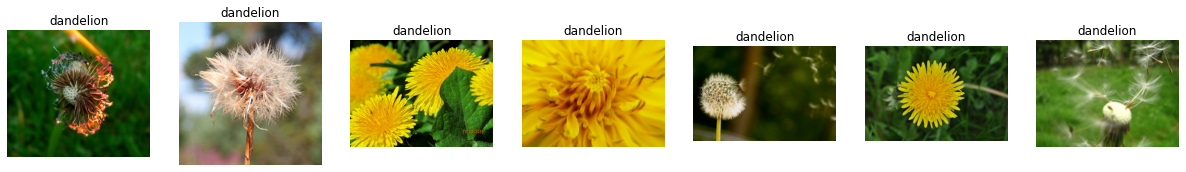

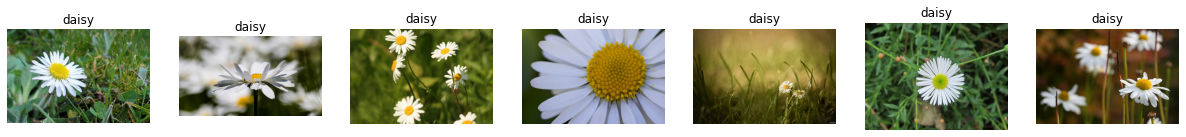

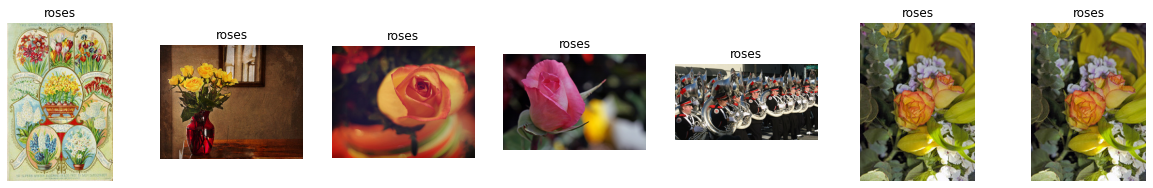

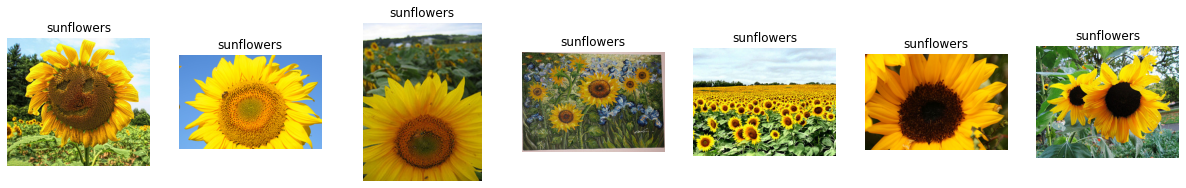

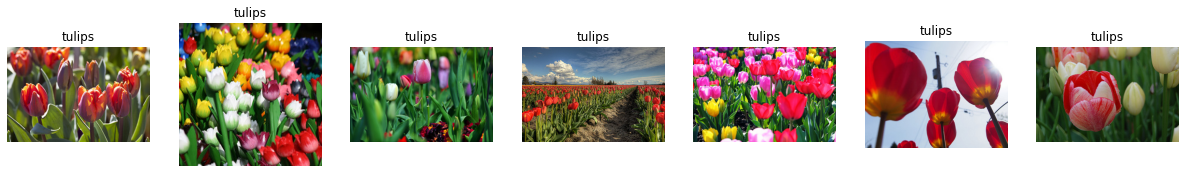

In [8]:
plot_flowers(dandelion, 'dandelion')
plot_flowers(daisy, 'daisy')
plot_flowers(roses, 'roses')
plot_flowers(sunflowers, 'sunflowers')
plot_flowers(tulips, 'tulips')

## Split The Data into X & y sets

In [9]:
#Create a dictonary contains all the images of each category
flowers_images_dict = {
    'roses': roses,
    'daisy':daisy ,
    'dandelion':dandelion ,
    'sunflowers':sunflowers ,
    'tulips': tulips,
}


#Create an other dictionary to associate each category to a integer number  
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [10]:
#img_size = 128
#img_size = 180
img_size = 130

In [11]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        #img = cv2.imread(str(image))
        resized_img = cv2.resize(image,(img_size,img_size))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])
        

In [12]:
all_data = []
for img, categ in zip(X, y):
    all_data.append([img, categ])

In [13]:
#Suffle the Data
random.shuffle(all_data)

In [14]:
X, y = [], []

for img, label in all_data :
    X.append(img)
    y.append(label)

As Keras accepts only arrays i have to convert my X and y which are a lists to an array

In [73]:
X = np.array(X)
y = np.array(y)

### Train test split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

X_val ,y_val = X_train[:500], y_train[:500]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [17]:
print('X_train shape :',X_train.shape)
print('X_test shape :',X_test.shape)
print('X_val shape :',X_val.shape)

X_train shape : (2752, 130, 130, 3)
X_test shape : (918, 130, 130, 3)
X_val shape : (500, 130, 130, 3)


### Data Augmentation

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. This reduces overfitting, making this a regularization technique. 

In [18]:
datagen = ImageDataGenerator(
                    rotation_range=45,     
                    width_shift_range=0.2,   
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='reflect'
)



i = 0
for batch in datagen.flow_from_directory(directory='flowers_imgs', 
                                         batch_size=16,  
                                         target_size=(256, 256),
                                         color_mode='rgb',
                                         save_to_dir='augmented_images_test', 
                                         save_prefix='aug', 
                                         save_format='png'):
    i += 1
    if i > 31:
        break       

Found 3670 images belonging to 5 classes.


After data augmentaion,all the generated images are located in the augmented_images_test folder, i will retreive twenty images in order to visualize them and make sur that they are reaslistic. In other words, human should not be able to tell whether it was augmented or not.

In [19]:
images_generated = []

for img_generated in os.listdir(path='augmented_images_test'):
    images = [img for img in cv2.imread(os.path.join('augmented_images_test',img_generated))]
    images_generated.append(images)
    if len(images_generated) == 20:
        break

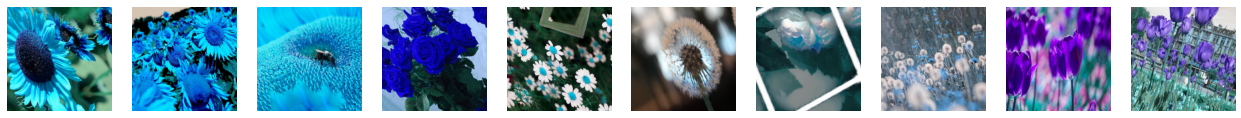

In [20]:
plt.figure(figsize=(22,9))

for i in range(0,10):
    plt.subplot(1,10,i+1)
    #plt.imshow(cv2.cvtColor(images_generated[i], cv2.COLOR_BGR2RGB))
    plt.imshow(images_generated[i]) 
    plt.axis('off')
    #plt.show()

The genarated flowers images seemed to be realistic,nothing to worry about about,so we can now continue our work

### Preprocessing: scale images

In [21]:
#X_train_scaled = X_train / 255.
#X_test_scaled = X_test / 255.

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)

X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_val - X_means) / X_stds
X_test_scaled  = (X_test - X_means) / X_stds


## Build Convolutional Neural Network 

> A brief description of my CNN :

- First, to avoid repetition i create a default Dense which contains the activation and the kernel_inialization that i will use in all my Dense Layers, and let the number of neurons to be dynamic.(It is applicable also for the Convolutional layer this technical)


- Second, i inialize the Sequential class into a variable named model wich allows us to build a model layer by layer


- Third, i build my CNN, it contains 3 convolutional layers followed by maxpooling layer 
   - __Convolutional layer__: it applies multiple learnable filters (kernels) to the image and outputs the result in a  feature map. Convolutional layers will automatically learn the most useful filters for its task and the             hidden layers will learn to combine them into more complex patterns
   - __MaxPooling__ :to shrink the input image in order to reduce compotutional load, memory usage and the number of         parameters (thereby limiting the risk of overfitting), MaxPooling introduces also some level of invariant to       small transaction
   - For more accurate analysis of images, I set the padding to 'Same' because kernels move across the images,             scanning each pixel and converting the data into a smaller, or sometimes larger, format. In order to assist         the kernel with processing the image,i add padding to the frame of the image to allow for more space for           the kernel to cover the image 


- Fouth, it cames the dense layers, i will first flatten to 1 dimensional the output of the convolutional layers and them fed it to the hidden layers, along with dropout layer to avoid overfitting; So our neurons end up being less senstive to slight change in the inputs and ultimately get a robust Network that generalizes better
   - Relu activation and he_normal inialization go hand by hand, He inialization to adress Vanishing/Exploding           Gradients problem thereby the signal could flow properly. The Relu activation does not saturate for positive      values  and it is quite fast to compute


- Finally , the output layer, wich contains the number of our classes (five in our case) and the softmax activation as we have multiclass to predict

In [23]:
#DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='selu',kernel_initializer='lecun_normal', padding='SAME')

DefaultDense = partial(keras.layers.Dense,
                               activation='relu',
                               kernel_initializer='he_normal')
                               #kernel_regularizer=keras.regularizers.l1(0.01))


model = Sequential()

#CNN
model.add(Conv2D(64, (5,5), strides=2, activation='relu', padding='SAME', input_shape=(img_size,img_size,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Dense
model.add(Flatten()) 
model.add(DefaultDense(128))
model.add(Dropout(rate=0.5))                           
model.add(DefaultDense(64))
model.add(Dropout(rate=0.5))                           
model.add(DefaultDense(32))
model.add(Dropout(rate=0.5))                           


model.add(Dense(5,activation='softmax'))

After our model is created, we must call its compile function to specify the loss function and the optimizer to use
   - I compile my model with the optimizer nadam beacause it is simply Adam Optimizer plus Nesterov Accelerated Gradient, and it is often converge slightly faster than Adam
   - I have a sparse lables( for each instances there is just a target class index from 0 to 5 in this case) so i set my my loss fucntion equals to sparse_categorical_crossentropy

To measure the performance of my model i choose the accuracy metric

In [24]:
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

- Another way to adress overfitting is to using Early Stopping, it will interrupt training when it measures no progress on the validation set (to avoid wasting time and resources)
- To reduce the learning rate during the training i use the the Performance Scheduling approach, it measures the validation error every N steps and reduce the leaerning rate by a factor when the error stops dropping

In [26]:
#checkpoint_cb = keras.callbacks.ModelCheckpoint('my_keras_model.h5')

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 3) #restore_best_weights=True

lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [27]:
history = model.fit(X_train_scaled, y_train, batch_size=32,
                        epochs=100,
                        validation_data=(X_valid_scaled, y_val),
                        callbacks=[early_stopping_cb, lr_scheduler])

Epoch 1/100
86/86 [==============================] - 42s 483ms/step - loss: 1.6206 - accuracy: 0.2616 - val_loss: 1.4306 - val_accuracy: 0.3900
Epoch 2/100
86/86 [==============================] - 41s 475ms/step - loss: 1.5091 - accuracy: 0.3594 - val_loss: 1.3362 - val_accuracy: 0.4400
Epoch 3/100
86/86 [==============================] - 41s 477ms/step - loss: 1.3718 - accuracy: 0.4041 - val_loss: 1.2241 - val_accuracy: 0.4980
Epoch 4/100
86/86 [==============================] - 41s 475ms/step - loss: 1.2867 - accuracy: 0.4542 - val_loss: 1.0463 - val_accuracy: 0.5800
Epoch 5/100
86/86 [==============================] - 41s 476ms/step - loss: 1.2286 - accuracy: 0.5011 - val_loss: 1.0583 - val_accuracy: 0.6300
Epoch 6/100
86/86 [==============================] - 41s 476ms/step - loss: 1.1551 - accuracy: 0.5156 - val_loss: 0.9227 - val_accuracy: 0.6400
Epoch 7/100
86/86 [==============================] - 42s 486ms/step - loss: 1.1409 - accuracy: 0.5334 - val_loss: 1.0925 - val_accuracy:

### Learning Curves

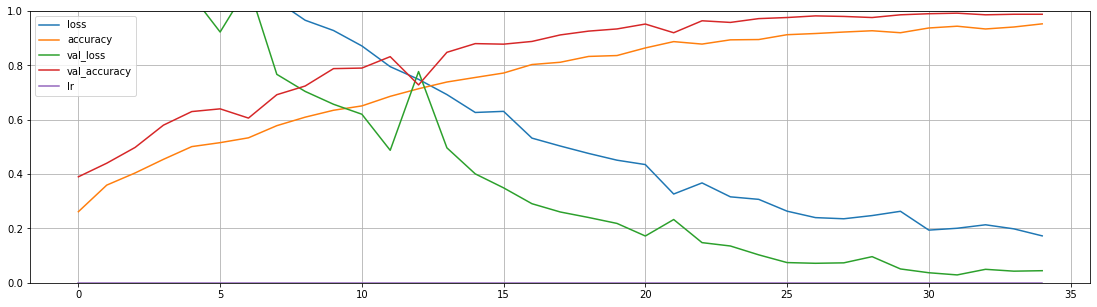

In [28]:
pd.DataFrame(history.history).plot(figsize=(19, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

The plot above shows us, the loss and val_loss is dropping during epochs while both accuracy and val_accuracy are increasing during training untill they reach a plateau

In [29]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 3s 115ms/step - loss: 1.6378 - accuracy: 0.7059


[1.637762427330017, 0.7058823704719543]

Although my model is not to much deep, and i get an accuracy equals almost to 70%. it is satisfactory score and need to be improved

I am going to train ly model with the generated images and see if they could improve the accuracy

In [30]:
#save my model for another use
model.save('first_keras_model.h5')

In [31]:
predictions = model.predict(X_test_scaled)
predictions

array([[1.2527435e-03, 2.8805146e-03, 6.3322060e-02, 9.1422874e-01,
        1.8315945e-02],
       [7.2187237e-02, 8.5553527e-02, 8.0997849e-01, 1.4353753e-02,
        1.7926950e-02],
       [1.1555718e-03, 3.6447211e-03, 2.1990408e-01, 7.6568663e-01,
        9.6090417e-03],
       ...,
       [3.2888872e-03, 7.7120657e-03, 9.7810704e-01, 9.2132967e-03,
        1.6786567e-03],
       [3.9166803e-06, 9.4362920e-05, 9.9990058e-01, 9.6965164e-07,
        1.3339304e-07],
       [7.3768377e-02, 1.8268306e-04, 4.7557678e-06, 4.5000089e-04,
        9.2559415e-01]], dtype=float32)

### Evaluate the Model

#### Confusion Matrix

In [32]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
#confusion_matrix(confusion_matrix(y_test, y_pred))
CM = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
                         #index = ['roses', 'daisy','dandelion','sunflowers','tulips'],
                         #columns= ['roses', 'daisy', 'dandelion','sunflowers','tulips'])

cm = sns.light_palette("green", as_cmap=True) 
CM.style.background_gradient(cmap=cm).set_precision(2)


Confusion Matrix


Predicted,0,1,2,3,4
Actual,,,,,
0,69,8,11,1,56
1,7,103,21,5,9
2,8,15,183,19,8
3,2,9,11,158,14
4,33,13,11,9,135


#### Classification report

In [33]:
def Classification_report(predictions):
        print('------------------------------------')
        y_pred = np.argmax(predictions, axis=1)
        print('Classification Report')
        target_names = ['roses', 'daisy', 'dandelion','sunflowers','tulips'] 
        print(classification_report(y_test, y_pred, target_names=target_names))
Classification_report(predictions)

------------------------------------
Classification Report
              precision    recall  f1-score   support

       roses       0.58      0.48      0.52       145
       daisy       0.70      0.71      0.70       145
   dandelion       0.77      0.79      0.78       233
  sunflowers       0.82      0.81      0.82       194
      tulips       0.61      0.67      0.64       201

    accuracy                           0.71       918
   macro avg       0.70      0.69      0.69       918
weighted avg       0.70      0.71      0.70       918



# Data Augmentation

In [34]:
datagen = ImageDataGenerator(
    
                    rotation_range=45,     
                    width_shift_range=0.2,   
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='reflect',
                    shuffle=True
) 

datagen.fit(X_train_scaled)

In [35]:
#checkpoint_cb_data_aug = keras.callbacks.ModelCheckpoint('my_keras_model_data_augmentation.h5')
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

History = model.fit_generator(datagen.flow(X_train_scaled, y_train,  batch_size=32),
                                      epochs = 100, 
                                      validation_data = (X_valid_scaled, y_val),
                                      callbacks=[early_stopping, lr_scheduler],
                                      steps_per_epoch = X_train_scaled.shape[0] // 32)

#steps_per_epoch * batch_size = number_of_rows_in_train_data


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
86/86 [==============================] - 47s 543ms/step - loss: 1.2681 - accuracy: 0.5531 - val_loss: 0.4293 - val_accuracy: 0.9280
Epoch 2/100
86/86 [==============================] - 46s 533ms/step - loss: 1.0277 - accuracy: 0.6239 - val_loss: 0.4875 - val_accuracy: 0.8920
Epoch 3/100
86/86 [==============================] - 46s 534ms/step - loss: 0.9650 - accuracy: 0.6355 - val_loss: 0.3575 - val_accuracy: 0.9260
Epoch 4/100
86/86 [==============================] - 45s 528ms/step - loss: 0.8944 - accuracy: 0.6697 - val_loss: 0.3920 - val_accuracy: 0.9080
Epoch 5/100
86/86 [==============================] - 46s 536ms/step - loss: 0.9113 - accuracy: 0.6770 - val_loss: 0.3886 - val_accuracy: 0.8920
Epoch 6/100
86/86 [==============================] - 47s 542ms/step - loss: 0.8603 - accuracy: 0.6791 - val_loss: 0.4118 - val_accuracy: 0.8940


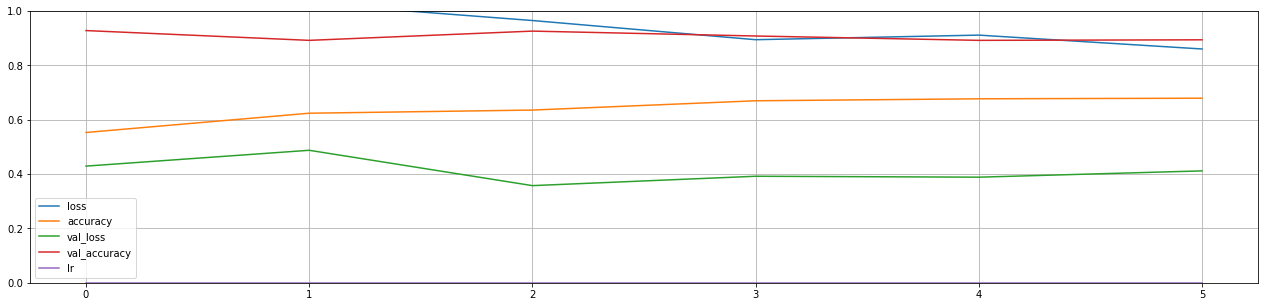

In [36]:
pd.DataFrame(History.history).plot(figsize=(22, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

In [38]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 4s 124ms/step - loss: 0.7918 - accuracy: 0.7505


[0.7918269634246826, 0.7505446672439575]

As i expected with data augmentation the accuracy goes from 70% to 75%

In [39]:
predictions_data_aug = model.predict(X_test_scaled)
predictions_data_aug

array([[1.00109167e-01, 1.09460846e-01, 3.33038509e-01, 2.75909245e-01,
        1.81482166e-01],
       [4.67879251e-02, 1.26390368e-01, 7.86940634e-01, 9.99845564e-03,
        2.98826098e-02],
       [1.16089368e-02, 3.16847377e-02, 2.22135067e-01, 6.51730120e-01,
        8.28411952e-02],
       ...,
       [4.19643819e-02, 5.44001423e-02, 4.09250945e-01, 3.59208316e-01,
        1.35176167e-01],
       [3.38981785e-02, 9.68029648e-02, 8.39847684e-01, 7.46806758e-03,
        2.19829921e-02],
       [4.21740532e-01, 3.67882010e-03, 4.82814881e-04, 9.05459654e-03,
        5.65043330e-01]], dtype=float32)

### Evaluate the Model

#### Confusion Matrix

In [72]:
y_pred = np.argmax(predictions_data_aug, axis=1)

print('Confusion Matrix')
CM = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cm = sns.light_palette('green', as_cmap=True) 
CM.style.background_gradient(cmap=cm).set_precision(2)


Confusion Matrix


Predicted,0,1,2,3,4
Actual,,,,,
0,79,13,14,1,38
1,12,116,9,5,3
2,5,18,188,19,3
3,2,6,11,165,10
4,24,19,12,5,141


#### Classification report

In [57]:
Classification_report(predictions_data_aug)

------------------------------------
Classification Report
              precision    recall  f1-score   support

       roses       0.65      0.54      0.59       145
       daisy       0.67      0.80      0.73       145
   dandelion       0.80      0.81      0.81       233
  sunflowers       0.85      0.85      0.85       194
      tulips       0.72      0.70      0.71       201

    accuracy                           0.75       918
   macro avg       0.74      0.74      0.74       918
weighted avg       0.75      0.75      0.75       918



In [41]:
#save the model
model.save('keras_model_data_augmentation.h5')